<a href="https://colab.research.google.com/github/magewade/face-recognition-project/blob/main/Face_Recognition_Project_DLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Project

Муравьева Мария
- Telegram @magewade
- Stepik 776465

## 1. Распознавание лиц на нейросети, предобученной на ImageNet

Начнем с выгрузки и просмотра датсета

In [1]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

file_id = "1h2L0BgVgiH2sfmExTNDn0LzYm-a35-4_"

output_file = "celebA-500.zip"
!gdown {file_id} -O {output_file}

os.makedirs('data', exist_ok=True)
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('data/')
    print("Done!")

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1h2L0BgVgiH2sfmExTNDn0LzYm-a35-4_
From (redirected): https://drive.google.com/uc?id=1h2L0BgVgiH2sfmExTNDn0LzYm-a35-4_&confirm=t&uuid=8dcf62ba-6310-4098-9745-d9e9d978cbd8
To: /content/celebA-500.zip
100% 170M/170M [00:05<00:00, 32.7MB/s]
Done!


Посмотрим на картинки

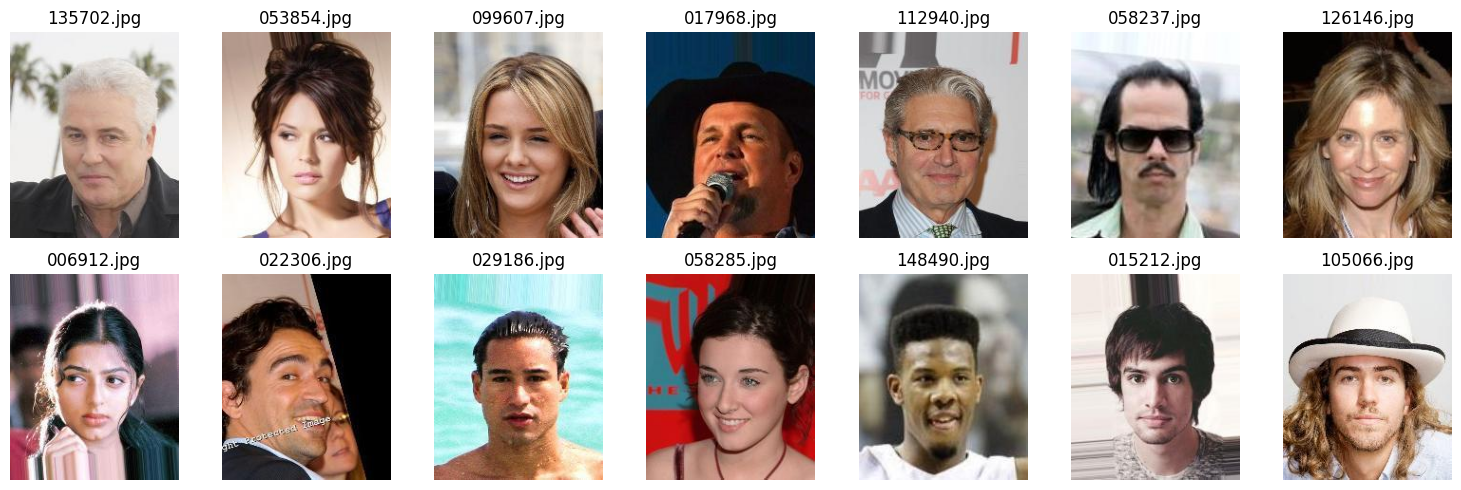

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

images_path = "/content/data/celebA_train_500/celebA_imgs"

image_files = os.listdir(images_path)
random_images = random.sample(image_files, 14)

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(images_path, img_name)
    img = Image.open(img_path)

    plt.subplot(2, 7, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
plt.tight_layout()
plt.show()


Лица уже выровнены, так что предварительной обработки датасета не требуется

Я решила прописать класс, так как у меня мало опыта с ооп, хоть попрактикуюсь, и я думаю, что в данном случае с парсингом двух текстовых файлов с аннотацией, так будет проще

Структура файлов такая

        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image


class CelebADataset(Dataset):
    def __init__(self, annotations_file, split_file, images_path, split="train", transform=None):
        """
        Инициализация датасета для CelebA
        :param annotations_file: Путь к файлу с аннотациями (имя_файла метка)
        :param split_file: Путь к файлу с разбиением (имя_файла split)
        :param images_path: Путь к папке с изображениями
        :param split: "train", "val" или "test"
        :param transform: Преобразования для изображений
        """
        self.images_path = images_path
        self.transform = transform

        self.annotations = {}
        with open(annotations_file, "r") as f:
            for line in f:
                img_name, label = line.strip().split()
                self.annotations[img_name] = int(label)

        self.image_splits = {}
        with open(split_file, "r") as f:
            for line in f:
                img_name, split_label = line.strip().split()
                self.image_splits[img_name] = int(split_label)

        split_mapping = {"train": 0, "val": 1, "test": 2}
        if split not in split_mapping:
            raise ValueError(f"Invalid split '{split}'. Must be 'train', 'val', or 'test'.")

        self.image_paths = [
            os.path.join(images_path, img_name)
            for img_name, split_label in self.image_splits.items()
            if split_label == split_mapping[split]
        ]
        self.labels = [self.annotations[os.path.basename(img_path)] for img_path in self.image_paths]

    def __len__(self):
        """Возвращает количество изображений в датасете"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Получение изображения и метки для индекса"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
id_file = "/content/data/celebA_train_500/celebA_anno.txt"
split_file = "/content/data/celebA_train_500/celebA_train_split.txt"
images_path = "/content/data/celebA_train_500/celebA_imgs"

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер изображений до 224x224 (для ResNet)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация по ImageNet
])

train_dataset = CelebADataset(id_file, split_file, images_path, split="train", transform=transform)
val_dataset = CelebADataset(id_file, split_file, images_path, split="val", transform=transform)
test_dataset = CelebADataset(id_file, split_file, images_path, split="test", transform=transform)

Тут было бы логичнее сразу посмотреть на картинки одного класса, а не выводить их обратно из тензора, но оставлю функцию на всякий случай

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def show_random_classes(dataset, num_classes=3, images_per_class=7):
    """
    Отображение изображений для случайных классов с их именами и метками.
    :param dataset: Датасет
    :param num_classes: Количество случайных классов для отображения
    :param images_per_class: Количество изображений на класс
    """
    unique_classes = list(set(label for _, label in dataset))

    selected_classes = random.sample(unique_classes, num_classes)

    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 2, num_classes * 2))
    axes = axes.flatten()

    idx = 0
    for target_class in selected_classes:
        filtered_images = [
            (dataset[i][0], dataset[i][1], dataset.image_paths[i].split("/")[-1])
            for i in range(len(dataset)) if dataset[i][1] == target_class
        ]

        for i in range(images_per_class):
            img, label, img_name = filtered_images[i]
            img = img.permute(1, 2, 0).numpy()  # Переводим тензор в изображение
            img = np.clip(img * 0.229 + 0.485, 0, 1)  # Денормализация для отображения

            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f"{target_class} - {img_name}")

            idx += 1

    plt.tight_layout()
    plt.show()

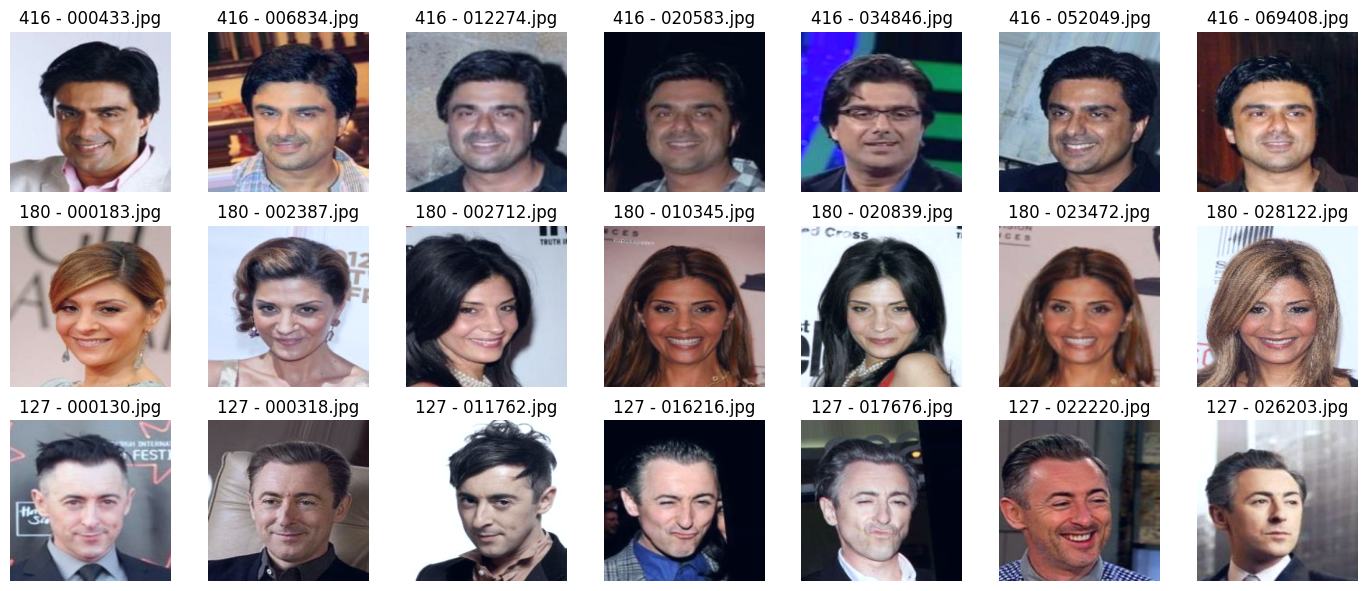

In [ ]:
show_random_classes(train_dataset, num_classes=3, images_per_class=7)

Буду использовать ResNet-50 для начала. Это позволит существенно ускорить обучение, так как модель уже знает базовые признаки объектов, такие как текстуры, края и формы, что полезно для распознавания лиц


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import models

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Я сначала попробовала реснет, но accuracy застревал около 45 процентов, решила сменить модель на efficientnet

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

# # Инициализируем модель ResNet50 с предобученными весами
# model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

# # Модифицируем последний слой для 500 классов
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 500)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

In [ ]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 500)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Я уже провела пару экспериментов и модель переобучалась, на трейне accuracy был уже близок к 100, а на валидации болтался около 50, попробую добавить оптимизатор, падающий лернинг рейт и буду считать метрику по кросс-валидации

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Падающий LR

num_epochs = 15

In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Оценка на валидации
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracies.append(100 * val_correct / val_total)
    print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")
    scheduler.step()

Epoch 1/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.79it/s]


Epoch 1/15 - Train Loss: 5.0201, Accuracy: 7.55%
Validation Accuracy: 21.09%


Epoch 2/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.80it/s]


Epoch 2/15 - Train Loss: 2.7719, Accuracy: 35.96%
Validation Accuracy: 45.53%


Epoch 3/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.77it/s]


Epoch 3/15 - Train Loss: 1.4182, Accuracy: 64.22%
Validation Accuracy: 54.15%


Epoch 4/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.82it/s]


Epoch 4/15 - Train Loss: 0.7381, Accuracy: 81.43%
Validation Accuracy: 60.44%


Epoch 5/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.81it/s]


Epoch 5/15 - Train Loss: 0.3997, Accuracy: 90.20%
Validation Accuracy: 65.39%


Epoch 6/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.77it/s]


Epoch 6/15 - Train Loss: 0.1493, Accuracy: 97.18%
Validation Accuracy: 72.26%


Epoch 7/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.72it/s]


Epoch 7/15 - Train Loss: 0.0691, Accuracy: 99.45%
Validation Accuracy: 73.70%


Epoch 8/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.79it/s]


Epoch 8/15 - Train Loss: 0.0509, Accuracy: 99.64%
Validation Accuracy: 74.12%


Epoch 9/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.76it/s]


Epoch 9/15 - Train Loss: 0.0419, Accuracy: 99.77%
Validation Accuracy: 74.44%


Epoch 10/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.80it/s]


Epoch 10/15 - Train Loss: 0.0331, Accuracy: 99.86%
Validation Accuracy: 75.29%


Epoch 11/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.80it/s]


Epoch 11/15 - Train Loss: 0.0297, Accuracy: 99.89%
Validation Accuracy: 75.35%


Epoch 12/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.80it/s]


Epoch 12/15 - Train Loss: 0.0271, Accuracy: 99.94%
Validation Accuracy: 75.35%


Epoch 13/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.80it/s]


Epoch 13/15 - Train Loss: 0.0270, Accuracy: 99.89%
Validation Accuracy: 75.19%


Epoch 14/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.82it/s]


Epoch 14/15 - Train Loss: 0.0251, Accuracy: 99.96%
Validation Accuracy: 75.40%


Epoch 15/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.79it/s]


Epoch 15/15 - Train Loss: 0.0248, Accuracy: 99.96%
Validation Accuracy: 75.61%


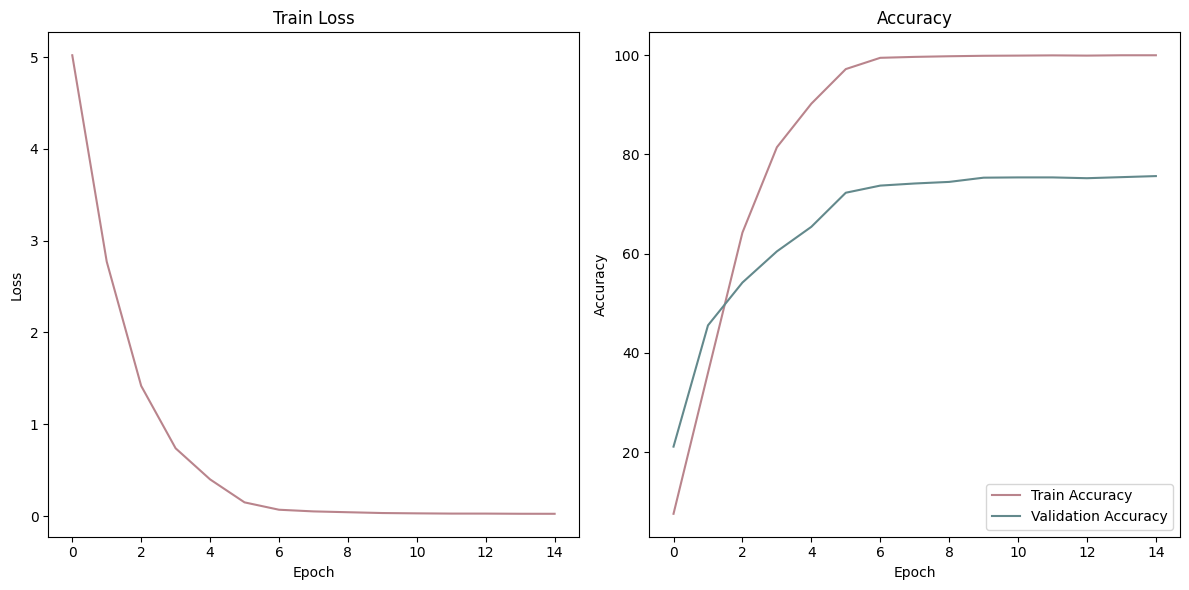

In [ ]:
plt.figure(figsize=(12, 6))

# График потери
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss', color='#B9848C')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy', color='#B9848C')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='#63898C')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 75.77%


Сохраню веса

In [ ]:
model_path = "efficientnet_finetuned.pth"

torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")


Model weights saved to efficientnet_finetuned.pth


##2. Identification Rate Metric

**Identification rate**

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [89]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

file_id = "1jjSH2RMPxsgdTnh9ApGry_2PfTbBnRty"

output_file = "celebA_ir.zip"
!gdown {file_id} -O {output_file}

os.makedirs('data', exist_ok=True)

with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('data/')
    print("Done!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading...
From (original): https://drive.google.com/uc?id=1jjSH2RMPxsgdTnh9ApGry_2PfTbBnRty
From (redirected): https://drive.google.com/uc?id=1jjSH2RMPxsgdTnh9ApGry_2PfTbBnRty&confirm=t&uuid=e8ef8c6d-5994-4f17-b5c3-4a246e131436
To: /content/celebA_ir.zip
100% 9.19M/9.19M [00:00<00:00, 18.7MB/s]
Done!


Подргужу веса для модели

In [90]:
import torch
import torchvision.models as models

model = models.efficientnet_b0(weights=None)
print(model.classifier)

num_classes = 500
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, num_classes)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [91]:
weights_path = "/content/efficientnet_finetuned.pth"
state_dict = torch.load(weights_path, map_location=torch.device('cuda'))

model.load_state_dict(state_dict)
print("Weights successfully loaded!")

Weights successfully loaded!


<ipython-input-91-0d690d44b167>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cuda'))


In [92]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('/content/data/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('/content/data/celebA_ir/celebA_distractors')

In [93]:
import torch
from torchvision import transforms
from PIL import Image
import os # Import the os module

def compute_embeddings(model, images_list, images_dir):
    '''
    Compute embeddings from the trained model for a list of images.
    Params:
        model: trained NN model that takes images and outputs embeddings
        images_list: list of image paths to compute embeddings for
        images_dir: directory where the images are located # Add documentation for images_dir
    Output:
        list: list of model embeddings. Each embedding corresponds to image
              names from images_list
    '''
    model.eval()
    embeddings = []


    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    with torch.no_grad():
        for img_name in images_list:
            img_path = os.path.join(images_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            input_tensor = preprocess(img).unsqueeze(0)
            embedding = model(input_tensor)
            embeddings.append(embedding.squeeze(0).cpu().numpy())  # Remove batch dimension and convert to numpy

    return embeddings

In [94]:
query_embeddings = compute_embeddings(model, query_img_names, '/content/data/celebA_ir/celebA_query')
distractors_embeddings = compute_embeddings(model, distractors_img_names, '/content/data/celebA_ir/celebA_distractors')

In [95]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    Compute cosine similarities between positive pairs from query (stage 1).
    '''
    similarities = []
    for img_class, images in query_dict.items():
        embeddings = [query_embeddings[query_img_names.index(img)] for img in images]
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                similarities.append(sim)
    return similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    Compute cosine similarities between negative pairs from query (stage 2).
    '''
    similarities = []
    all_classes = list(query_dict.keys())
    for i in range(len(all_classes)):
        for j in range(i + 1, len(all_classes)):
            class_i_images = query_dict[all_classes[i]]
            class_j_images = query_dict[all_classes[j]]
            embeddings_i = [query_embeddings[query_img_names.index(img)] for img in class_i_images]
            embeddings_j = [query_embeddings[query_img_names.index(img)] for img in class_j_images]
            for emb_i in embeddings_i:
                for emb_j in embeddings_j:
                    sim = cosine_similarity([emb_i], [emb_j])[0][0]
                    similarities.append(sim)
    return similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    Compute cosine similarities between query and distractors (stage 3).
    '''
    similarities = []
    for query_emb in query_embeddings:
        for distractor_emb in distractors_embeddings:
            sim = cosine_similarity([query_emb], [distractor_emb])[0][0]
            similarities.append(sim)
    return similarities

In [96]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


In [97]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [98]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

print('Done')

Done


Ассерты проходят

In [99]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    '''
    Compute identification rate (TPR@FPR) at a given false positive rate.
    '''
    false_pairs = cosine_query_neg + cosine_query_distractors
    false_pairs = sorted(false_pairs, reverse=True)
    num_false_pairs = len(false_pairs)
    allowed_false_positives = int(fpr * num_false_pairs)
    threshold = false_pairs[allowed_false_positives]
    true_positive_count = sum(1 for sim in cosine_query_pos if sim > threshold) # Iterate and count based on threshold
    total_positive_pairs = len(cosine_query_pos)


    tpr = true_positive_count / total_positive_pairs if total_positive_pairs > 0 else 0 # Normalize by total positive pairs

    return threshold, tpr

In [100]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [101]:
np.array(test_thr)

array([-0.01198273,  0.33714266,  0.7013071 ])

In [102]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

print('Done')

Done


Ассерты проходят

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [ ]:
fpr_values = [0.5, 0.2, 0.1, 0.05]

test_thr = []
test_tpr = []

for fpr in fpr_values:
    threshold, tpr = compute_ir(cosine_query_pos, cosine_query_neg,
                                cosine_query_distractors, fpr=fpr)
    test_thr.append(threshold)
    test_tpr.append(tpr)

for i, fpr in enumerate(fpr_values):
    print(f"FPR: {fpr}, Threshold: {test_thr[i]}, TPR: {test_tpr[i]}")

FPR: 0.5, Threshold: 0.9732550382614136, TPR: 0.8001494463691325
FPR: 0.2, Threshold: 0.9822213649749756, TPR: 0.5329121662930507
FPR: 0.1, Threshold: 0.9857659935951233, TPR: 0.3736838529991169
FPR: 0.05, Threshold: 0.9881701469421387, TPR: 0.2546022688676041


Снижение FPR приводит к увеличению порога для определения положительных примеров, что в свою очередь приводит к снижению TPR.

Модель становится более строгой и снижает количество ложных срабатываний (FPR), но при этом теряет способность распознавать некоторые положительные примеры (снижение TPR).

На высоком FPR (например, 0.5) модель может идентифицировать большинство положительных примеров (высокий TPR), но будет ошибаться в идентификации отрицательных примеров (высокие ложные срабатывания).

С уменьшением FPR модель становится более осторожной, что снижает количество ложных срабатываний, но также ухудшается способность находить все положительные примеры (снижается TPR).

Вывод: Эти результаты показывают хороший компромисс между TPR и FPR в задаче распознавания лиц или идентификации, где можно регулировать, сколько ложных срабатываний можно допустить для получения более высокой точности в распознавании лиц.

## 3. ArcFace Loss (Additive Angular Margin Loss)

ArcFace Loss — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss заcтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

Обучу на этом лоссе ту же efficientnet, что в первом шаге

Для использования ArcFace Loss, нужно изменить структуру модели, чтобы она вместо логитов (выходов model.classifier) выдавала эмбеддинги фиксированной размерности (например, 512). Затем лосс будет использовать эти эмбеддинги для вычисления модифицированных логитов с учетом углового смещения и нормализации.

In [ ]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

file_id = "1h2L0BgVgiH2sfmExTNDn0LzYm-a35-4_"

output_file = "celebA-500.zip"
!gdown {file_id} -O {output_file}

os.makedirs('data', exist_ok=True)
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('data/')
    print("Done!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading...
From (original): https://drive.google.com/uc?id=1h2L0BgVgiH2sfmExTNDn0LzYm-a35-4_
From (redirected): https://drive.google.com/uc?id=1h2L0BgVgiH2sfmExTNDn0LzYm-a35-4_&confirm=t&uuid=dce754f9-34c1-483a-a472-33f67763c3bc
To: /content/celebA-500.zip
100% 170M/170M [00:01<00:00, 121MB/s]
Done!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_dim, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
        normalized_weights = F.normalize(self.weight, p=2, dim=1)

        cos_theta = torch.matmul(normalized_embeddings, normalized_weights.T).clamp(-1.0, 1.0)
        theta = torch.acos(cos_theta)
        target_logit = torch.cos(theta + self.m)

        one_hot = torch.zeros_like(cos_theta, device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        logits = one_hot * target_logit + (1.0 - one_hot) * cos_theta
        logits *= self.s

        if torch.isnan(logits).any():
            print("Warning: NaN in logits")

        loss = F.cross_entropy(logits, labels)
        return loss


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import models

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
embedding_dim = 128  # Размерность эмбеддингов
num_classes = 500

# Замена последнего слоя для вывода эмбеддингов
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, embedding_dim),
    nn.BatchNorm1d(embedding_dim),
    nn.ReLU()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

arcface_loss = ArcFaceLoss(num_classes=num_classes, embedding_dim=embedding_dim, s=10.0, m=0.35).to(device)

optimizer = torch.optim.Adam([
    {"params": model.parameters()},
    {"params": arcface_loss.parameters()}  # Добавляем параметры лосса
], lr=1e-3, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 15


In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Прямой проход
        embeddings = model(images)
        loss = arcface_loss(embeddings, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)  # Нормализация эмбеддингов
        cos_theta = torch.matmul(normalized_embeddings, arcface_loss.weight.T)  # Cosine similarity
        _, predicted = torch.max(cos_theta, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Валидация
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)

            normalized_embeddings = F.normalize(embeddings, p=2, dim=1)  # Нормализация эмбеддингов
            cos_theta = torch.matmul(normalized_embeddings, arcface_loss.weight.T)  # Cosine similarity
            _, predicted = torch.max(cos_theta, dim=1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracies.append(100 * val_correct / val_total)
    print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")
    scheduler.step()

Epoch 1/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.72it/s]


Epoch 1/15 - Train Loss: 8.8159, Accuracy: 5.33%
Validation Accuracy: 14.27%


Epoch 2/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.76it/s]


Epoch 2/15 - Train Loss: 7.5028, Accuracy: 21.80%
Validation Accuracy: 27.05%


Epoch 3/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.77it/s]


Epoch 3/15 - Train Loss: 6.6480, Accuracy: 40.73%
Validation Accuracy: 35.52%


Epoch 4/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.75it/s]


Epoch 4/15 - Train Loss: 5.8642, Accuracy: 54.62%
Validation Accuracy: 43.50%


Epoch 5/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.76it/s]


Epoch 5/15 - Train Loss: 5.0363, Accuracy: 65.61%
Validation Accuracy: 52.88%


Epoch 6/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.79it/s]


Epoch 6/15 - Train Loss: 3.7893, Accuracy: 83.80%
Validation Accuracy: 67.94%


Epoch 7/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.77it/s]


Epoch 7/15 - Train Loss: 3.2790, Accuracy: 90.34%
Validation Accuracy: 69.70%


Epoch 8/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.73it/s]


Epoch 8/15 - Train Loss: 2.9949, Accuracy: 92.81%
Validation Accuracy: 69.97%


Epoch 9/15: 100%|█████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.76it/s]


Epoch 9/15 - Train Loss: 2.7728, Accuracy: 94.22%
Validation Accuracy: 70.87%


Epoch 10/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.74it/s]


Epoch 10/15 - Train Loss: 2.5727, Accuracy: 95.72%
Validation Accuracy: 71.73%


Epoch 11/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.73it/s]


Epoch 11/15 - Train Loss: 2.3730, Accuracy: 96.55%
Validation Accuracy: 71.99%


Epoch 12/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.76it/s]


Epoch 12/15 - Train Loss: 2.3469, Accuracy: 97.00%
Validation Accuracy: 71.57%


Epoch 13/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.73it/s]


Epoch 13/15 - Train Loss: 2.3314, Accuracy: 96.83%
Validation Accuracy: 71.83%


Epoch 14/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.77it/s]


Epoch 14/15 - Train Loss: 2.3036, Accuracy: 97.05%
Validation Accuracy: 71.88%


Epoch 15/15: 100%|████████████████████████████████████████████████| 267/267 [00:39<00:00,  6.74it/s]


Epoch 15/15 - Train Loss: 2.2840, Accuracy: 97.31%
Validation Accuracy: 72.20%


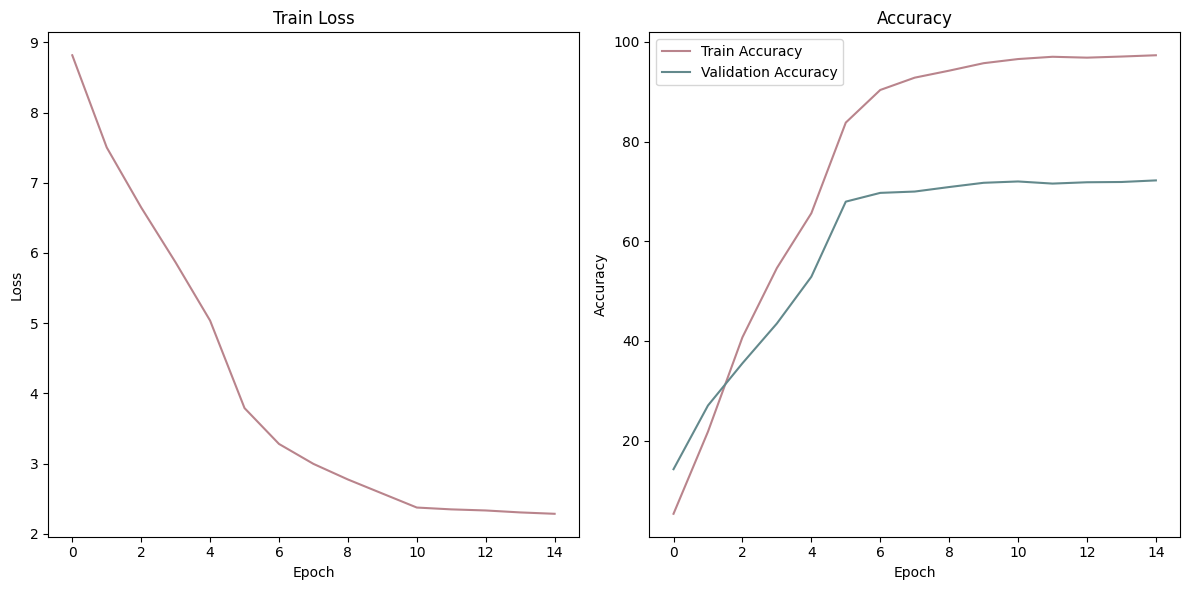

In [ ]:
plt.figure(figsize=(12, 6))

# График потери
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss', color='#B9848C')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy', color='#B9848C')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='#63898C')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        embeddings = model(images)
        cos_theta = torch.matmul(embeddings, arcface_loss.weight.T)  # Косинусное сходство
        _, predicted = torch.max(cos_theta, dim=1)  # Предсказания

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


Test Accuracy: 73.76%


Вроде все получилось, сохраню веса

In [ ]:
model_path = "efficientnet_arcface.pth"

torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

Model weights saved to efficientnet_arcface.pth


## 4. Визуализация эмбеддингов

**t-SNE/PCA**

Один из самых популярных методов визуализации высокоразмерных данных — это t-SNE (t-Distributed Stochastic Neighbor Embedding) или PCA (Principal Component Analysis). Оба этих метода позволяют уменьшить размерность эмбеддингов (например, 128D) до 2D или 3D, чтобы визуализировать, как данные сгруппированы. Например, можно визуализировать эмбеддинги всех лиц на тренировочном наборе, чтобы понять, как модели удается различать разные классы.

Когда мы исследуем пространство эмбеддингов, нас интересует, как модель распределяет эмбеддинги для различных классов и как она решает, какие эмбеддинги близки друг другу, а какие — далеко.

https://medium.com/@aastha.code/dimensionality-reduction-pca-t-sne-and-umap-41d499da2df2

Подгружу веса

In [4]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch

model = efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')

embedding_dim = 128
num_classes = 500

model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, embedding_dim),
    nn.BatchNorm1d(embedding_dim),
    nn.ReLU()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s]


In [6]:
weights_path = "/content/efficientnet_arcface.pth"
state_dict = torch.load(weights_path, map_location=torch.device('cuda'))

model.load_state_dict(state_dict)
print("Weights successfully loaded!")

Weights successfully loaded!


<ipython-input-6-d9285ca806ec>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cuda'))


In [70]:
import torch
from torch.utils.data import Dataset
from torchvision import models, transforms
from PIL import Image

class CelebADatasetWithEmbeddings(Dataset):
    def __init__(self, annotations_file, split_file, images_path, split="train", transform=None, model=None, device="cuda"):
        """
        Инициализация датасета для CelebA с извлечением эмбеддингов.
        :param annotations_file: Путь к файлу с аннотациями (имя_файла метка)
        :param split_file: Путь к файлу с разбиением (имя_файла split)
        :param images_path: Путь к папке с изображениями
        :param split: "train", "val" или "test"
        :param transform: Преобразования для изображений
        :param model: Предобученная модель для извлечения эмбеддингов
        :param device: Устройство для модели ("cuda" или "cpu")
        """
        self.images_path = images_path
        self.transform = transform
        self.model = model.to(device)  # Переводим модель на нужное устройство
        self.device = device

        self.annotations = {}
        with open(annotations_file, "r") as f:
            for line in f:
                img_name, label = line.strip().split()
                self.annotations[img_name] = int(label)

        self.image_splits = {}
        with open(split_file, "r") as f:
            for line in f:
                img_name, split_label = line.strip().split()
                self.image_splits[img_name] = int(split_label)

        split_mapping = {"train": 0, "val": 1, "test": 2}
        if split not in split_mapping:
            raise ValueError(f"Invalid split '{split}'. Must be 'train', 'val', or 'test'.")

        self.image_paths = [
            os.path.join(images_path, img_name)
            for img_name, split_label in self.image_splits.items()
            if split_label == split_mapping[split]
        ]
        self.labels = [self.annotations[os.path.basename(img_path)] for img_path in self.image_paths]

    def __len__(self):
        """Возвращает количество изображений в датасете"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Получение изображения и метки для индекса с эмбеддингом"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        image = image.unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(image).cpu().numpy().flatten()

        return image, label, embedding

In [71]:
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_with_embeddings = CelebADatasetWithEmbeddings(id_file, split_file, images_path, split="train", transform=transform, model=model, device='cuda')
val_dataset_with_embeddings = CelebADatasetWithEmbeddings(id_file, split_file, images_path, split="val", transform=transform, model=model, device='cuda')
test_dataset_with_embeddings = CelebADatasetWithEmbeddings(id_file, split_file, images_path, split="test", transform=transform, model=model, device='cuda')

train_embeddings = []
train_labels = []

model.eval()

for img, label, embedding in train_dataset_with_embeddings:
    train_embeddings.append(embedding)
    train_labels.append(label)

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)


In [72]:
from matplotlib.colors import LinearSegmentedColormap

hex_colors = ['#181D3B', '#3C4A79', '#F6D98F', '#CC979F', '#833E5B']
cmap = LinearSegmentedColormap.from_list("custom_cmap", hex_colors)

**PCA** — это метод линейного снижения размерности, который позволяет уменьшить количество признаков в данных, сохраняя как можно больше информации. Он ищет направления, называемые главными компонентами, вдоль которых данные имеют максимальную дисперсию.

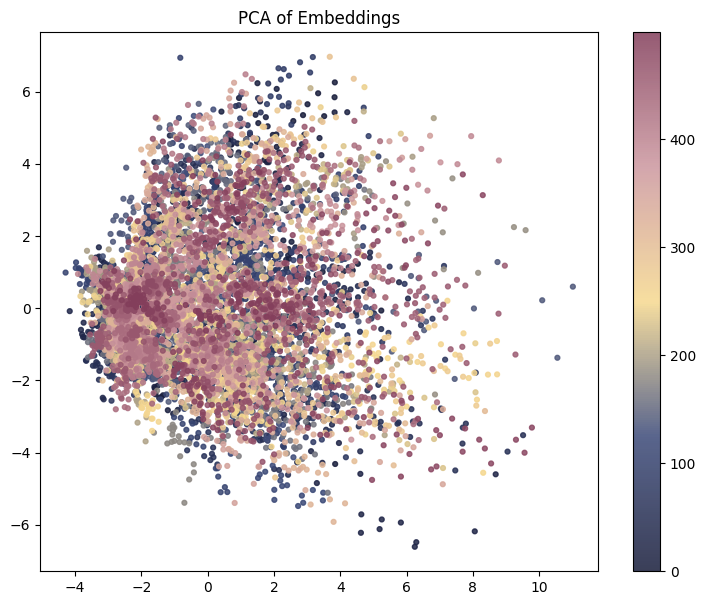

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Применяем PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(train_embeddings)

plt.figure(figsize=(9, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=train_labels, cmap=cmap, alpha=0.85, s=12)  # Уменьшаем размер точек, если много данных
plt.colorbar()
plt.title("PCA of Embeddings")
plt.show()

**t-SNE** — это метод нелинейного снижения размерности, специально разработанный для визуализации высокоразмерных данных в 2D или 3D. Он пытается сохранить локальную структуру данных, то есть точки, которые были близки в исходном пространстве, остаются близкими в проекции.

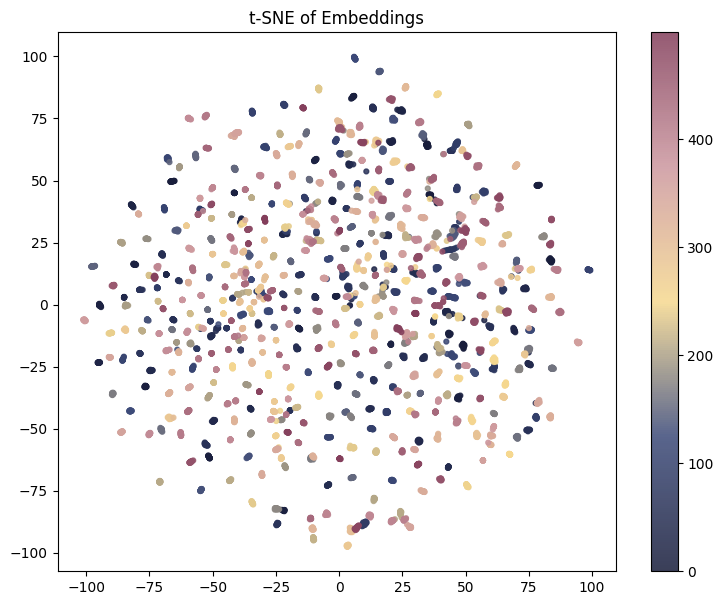

In [74]:
from sklearn.manifold import TSNE

# Применяем t-SNE
tsne = TSNE(n_components=2, random_state=42, max_iter=1000)
reduced_embeddings_tsne = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(9, 7))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=train_labels, cmap=cmap, alpha=0.85, s=12)
plt.colorbar()
plt.title("t-SNE of Embeddings")
plt.show()


На всех 500 классах кластеры не сильно прослеживаются, посмотрим на первые 25

In [75]:
selected_classes = [i for i in range(0, 24)]

selected_embeddings = []
selected_labels = []

for emb, lbl in zip(train_embeddings, train_labels):
    if lbl.item() in selected_classes:
        selected_embeddings.append(torch.from_numpy(emb)) # Convert to Tensor
        selected_labels.append(lbl)

selected_embeddings = torch.stack(selected_embeddings)
selected_labels = torch.tensor(selected_labels)

selected_embeddings = selected_embeddings.numpy()
selected_labels = selected_labels.numpy()

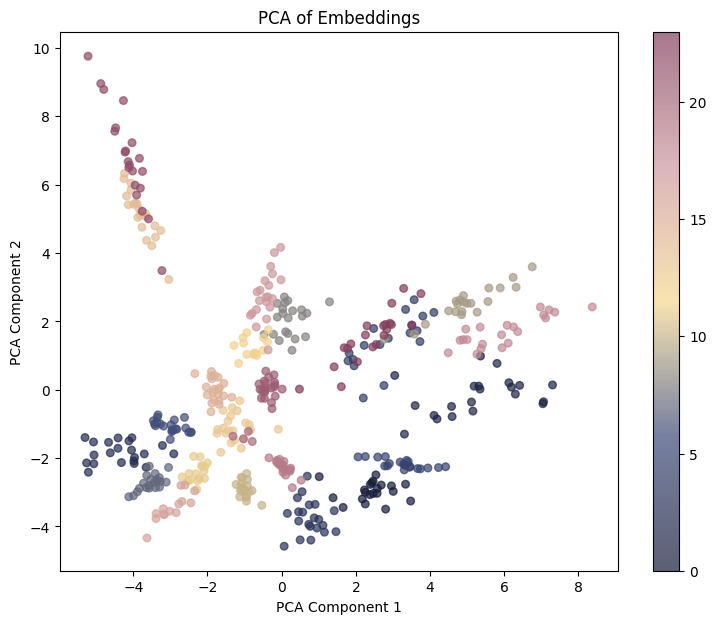

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Применяем PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(selected_embeddings)

plt.figure(figsize=(9, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=selected_labels, cmap=cmap, alpha=0.7, s=30)
plt.colorbar()
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


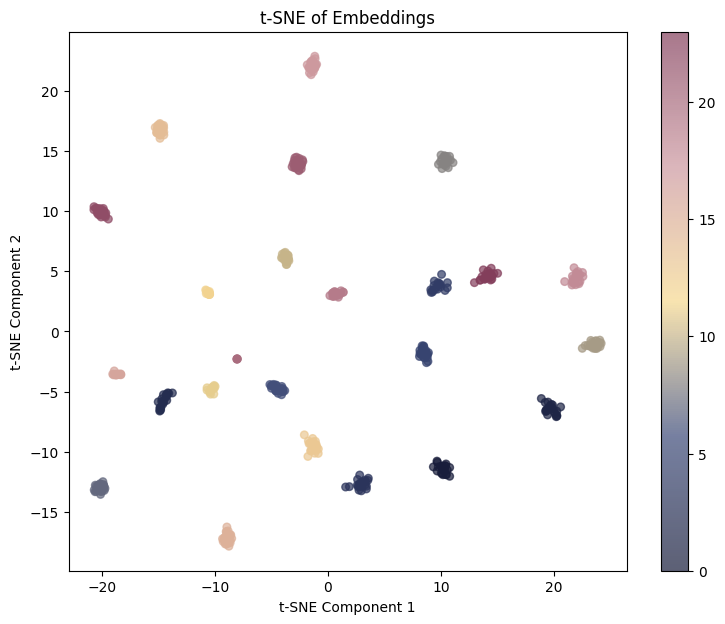

In [77]:
from sklearn.manifold import TSNE

# Применяем t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(selected_embeddings)

plt.figure(figsize=(9, 7))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=selected_labels, cmap=cmap, alpha=0.7, s=30)
plt.colorbar()
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


Очень красивые кластеры

Дальше буду искать выбросы именно на t-SNE, хочу протестить два метода - Isolation Forest и DBSCAN

Статьи:
- https://medium.com/pythons-gurus/clustering-faces-with-python-aef799514cd8
- https://medium.com/biased-algorithms/dbscan-for-outlier-detection-in-python-d24a9c949a50
- https://medium.com/@arpitbhayani/isolation-forest-algorithm-for-anomaly-detection-f88af2d5518d

**Isolation Forest** — это метод машинного обучения для обнаружения выбросов (outliers), основанный на построении деревьев и использовании свойства, что выбросы проще «изолировать», чем обычные точки.

In [78]:
from sklearn.ensemble import IsolationForest

# Применяем Isolation Forest
iso_forest = IsolationForest(contamination=0.05)  # Укажем предполагаемый процент аутлайеров
outlier_predictions = iso_forest.fit_predict(reduced_embeddings_tsne)

# Аутлайеры будут иметь метку -1
outliers = np.where(outlier_predictions == -1)[0]
print(f"Found {len(outliers)} outliers")


Found 23 outliers


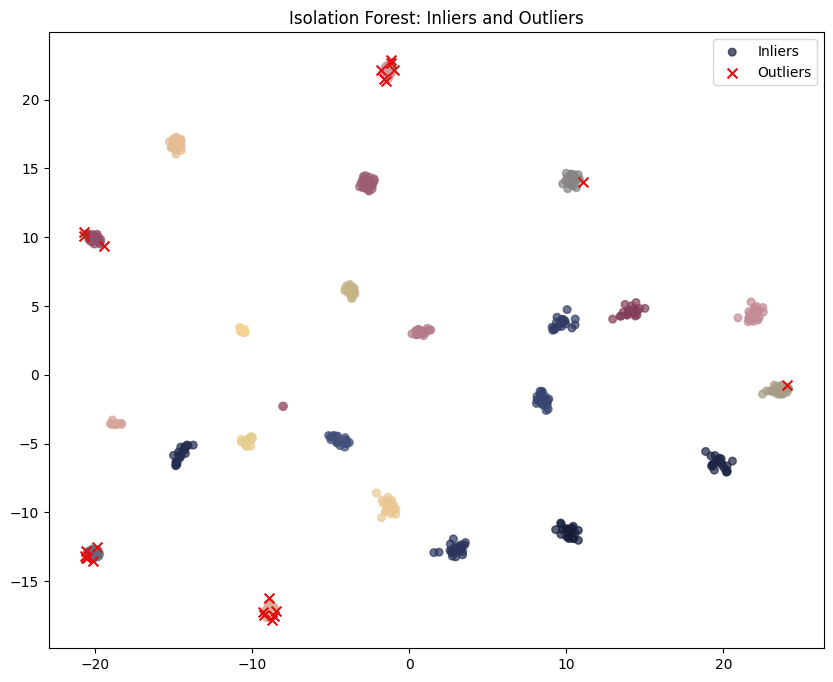

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest

inliers = np.where(outlier_predictions != -1)[0]

plt.figure(figsize=(10, 8))

plt.scatter(reduced_embeddings_tsne[inliers, 0], reduced_embeddings_tsne[inliers, 1],
            c=train_labels[inliers], cmap=cmap, alpha=0.7, s=30, label='Inliers')

plt.scatter(reduced_embeddings_tsne[outliers, 0], reduced_embeddings_tsne[outliers, 1],
            color='#e00e0f', marker='x', s=50, label='Outliers')

plt.title("Isolation Forest: Inliers and Outliers")
plt.legend()
plt.show()


**DBSCAN** — это кластерный алгоритм, который выделяет кластеры на основе плотности точек и автоматически обнаруживает выбросы (обозначаются как точки шума, -1).

In [80]:
from sklearn.cluster import DBSCAN

# Применяем DBSCAN
db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
labels = db.fit_predict(reduced_embeddings_tsne)

# Аутлайеры будут иметь метку -1
outliers = np.where(labels == -1)[0]
print(f"Found {len(outliers)} outliers")


Found 14 outliers


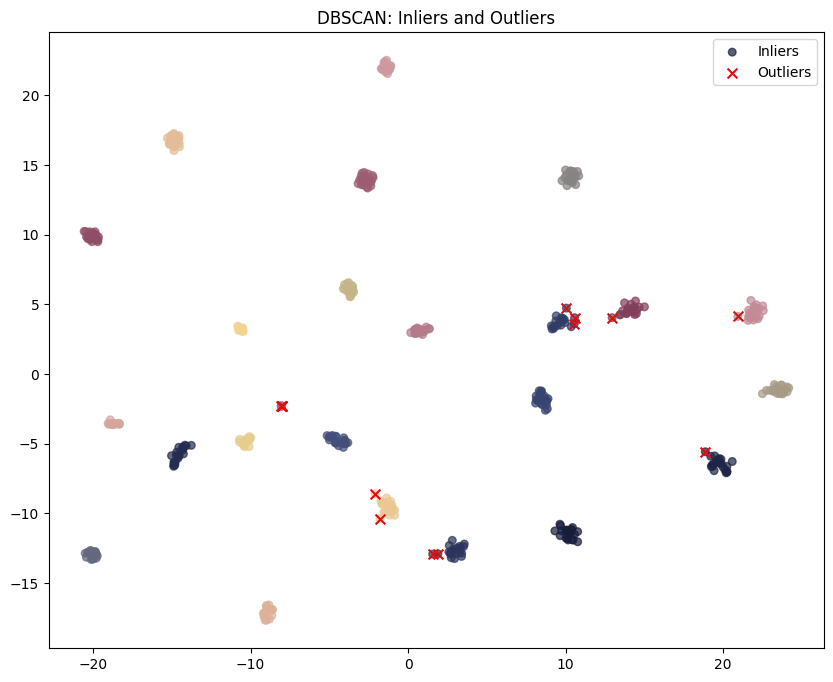

In [81]:
plt.figure(figsize=(10, 8))

plt.scatter(reduced_embeddings_tsne[inliers, 0], reduced_embeddings_tsne[inliers, 1],
            c=train_labels[inliers], cmap=cmap, alpha=0.7, s=30, label='Inliers')

plt.scatter(reduced_embeddings_tsne[outliers, 0], reduced_embeddings_tsne[outliers, 1],
            color='#e00e0f', marker='x', s=50, label='Outliers')

plt.title("DBSCAN: Inliers and Outliers")
plt.legend()
plt.show()


Вот тут мне нравится как выглядят выбросы на графике, посмотрим на них в картинках

In [82]:
def show_class_images(dataset, inliers, outliers, selected_classes, num_inliers=7, num_outliers=2):
    for class_label in selected_classes:
        class_inliers = [i for i in inliers if dataset[i][1] == class_label]
        class_outliers = [i for i in outliers if dataset[i][1] == class_label]

        if not class_outliers:
            continue

        selected_inliers = class_inliers[:num_inliers]  # Выбираем инлайеров для отображения
        selected_outliers = class_outliers[:num_outliers]  # Выбираем аутлайеров для отображения

        selected_inliers = [i for i in selected_inliers if i not in selected_outliers]

        selected_indices = selected_inliers + selected_outliers

        if selected_indices:
            num_images = len(selected_indices)
            fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
            if num_images == 1:
                axes = [axes]
            for i, idx in enumerate(selected_indices):
                image, label, _ = dataset[idx]

                image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
                image = (image - image.min()) / (image.max() - image.min())

                axes[i].imshow(image)
                axes[i].set_title(f"Class {label} - {'Inlier' if idx in selected_inliers else 'Outlier'}")
                axes[i].axis('off')

            plt.show()

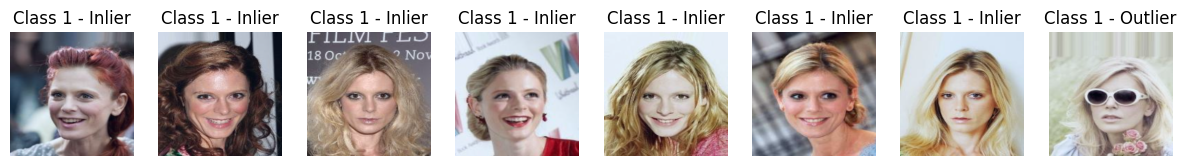

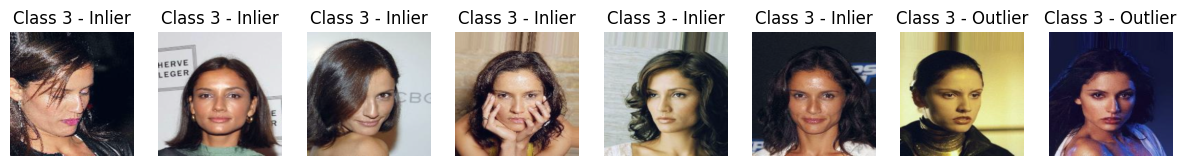

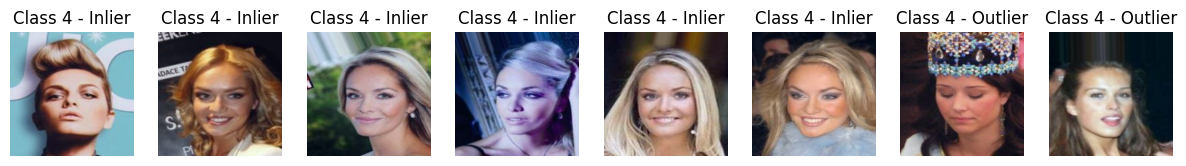

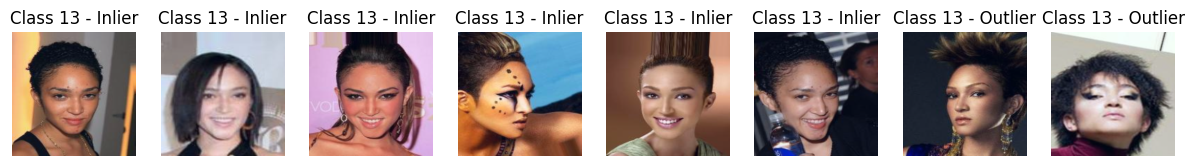

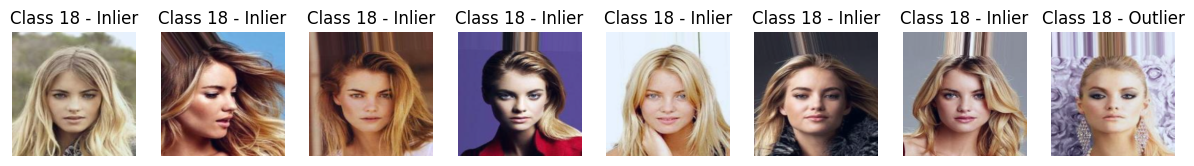

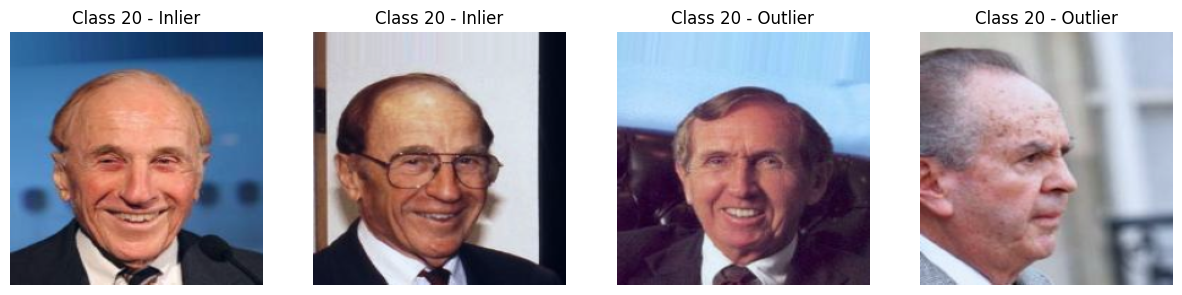

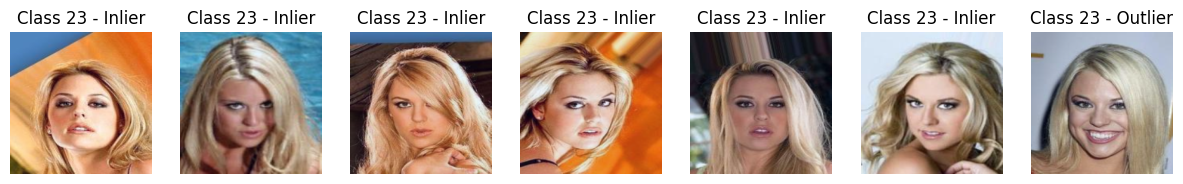

In [83]:
show_class_images(train_dataset_with_embeddings, inliers, outliers, selected_classes)

Ну, в целом, выглядит адекватно, особенно для класса 4, также в выбросах фото в очках или с прической, со странным освещением, или просто другие люди - ошибки в разметке

Попробую для интереса глазками поискать смазанное или странное фото, чтобы проверить целенаправленно, найдется ли оно в выбросах

Вот нашла однозначную ошибку сортировки - класс 345 - прекрасная Anna Gunn, фото 081234 явно не она, ожидаю что по эмбеддингам эта картинка будет аутлаером, проверим

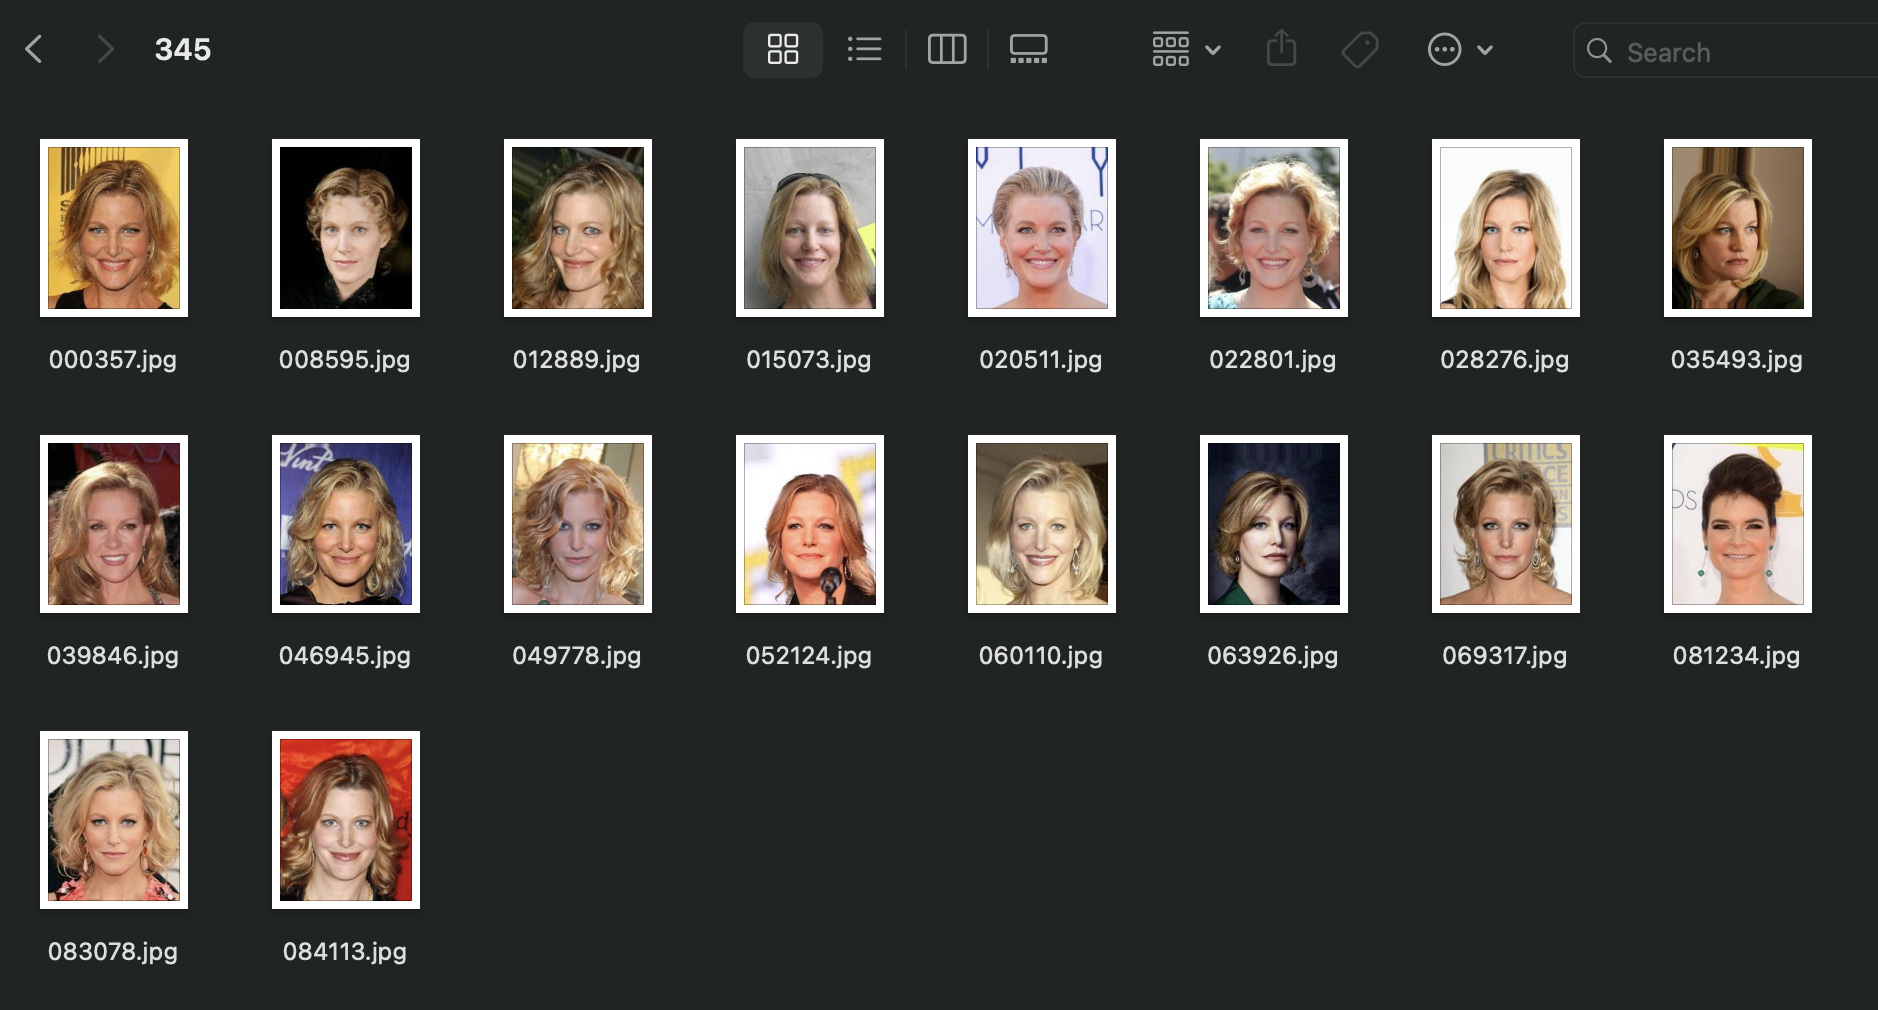

In [84]:
selected_classes = [i for i in range(340, 351)]

selected_embeddings = []
selected_labels = []
global_indices = []

for idx, (emb, lbl) in enumerate(zip(train_embeddings, train_labels)):
    if lbl in selected_classes:
        selected_embeddings.append(torch.from_numpy(emb))  # Convert to Tensor
        selected_labels.append(lbl)
        global_indices.append(idx)  # Сохраняем глобальный индекс


selected_embeddings = torch.stack(selected_embeddings)
selected_labels = torch.tensor(selected_labels)

selected_embeddings = selected_embeddings.numpy()
selected_labels = selected_labels.numpy()

In [85]:
# Пересчет T-SNE и кластеризации на отфильтрованных данных
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(selected_embeddings)

db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
labels = db.fit_predict(reduced_embeddings_tsne)

outliers_relative = np.where(labels == -1)[0]  # Относительные индексы
outliers_global = [global_indices[i] for i in outliers_relative]  # Глобальные индексы

# Пересчитываем инлайнеров и аутлайнеров
inliers = np.where(labels != -1)[0]
outliers = np.where(labels == -1)[0]

print(f"Found {len(outliers)} outliers")


Found 1 outliers


Подозреваю, это как раз наш пациент

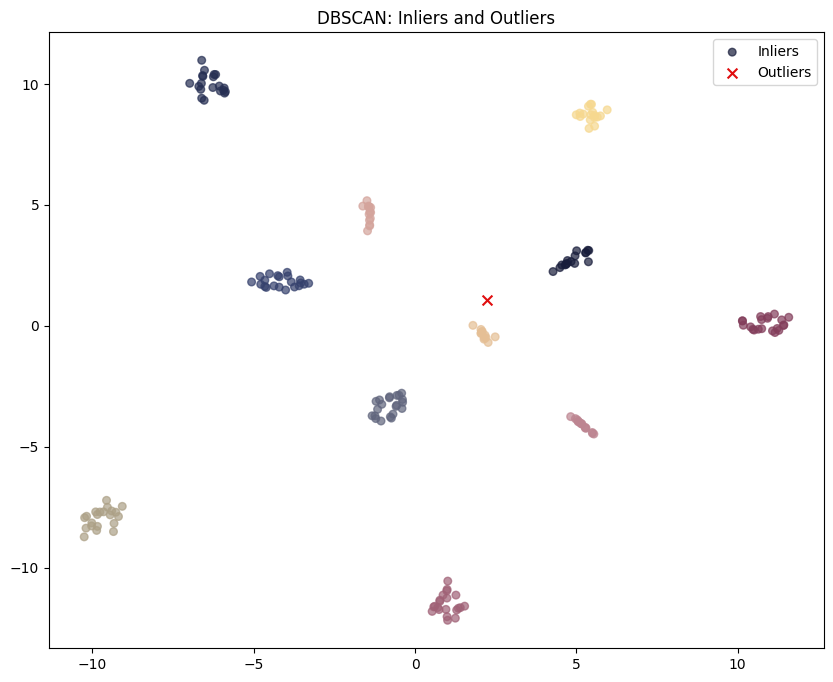

In [86]:
plt.figure(figsize=(10, 8))
filtered_inliers = [i for i in inliers if i < len(reduced_embeddings_tsne)]
filtered_labels = [selected_labels[i] for i in filtered_inliers]

plt.scatter(reduced_embeddings_tsne[filtered_inliers, 0], reduced_embeddings_tsne[filtered_inliers, 1],
            c=filtered_labels, cmap=cmap, alpha=0.7, s=30, label='Inliers')

filtered_outliers = [i for i in outliers if i < len(reduced_embeddings_tsne)]

plt.scatter(reduced_embeddings_tsne[filtered_outliers, 0], reduced_embeddings_tsne[filtered_outliers, 1],
            color='#e00e0f', marker='x', s=50, label='Outliers')

plt.title("DBSCAN: Inliers and Outliers")
plt.legend()
plt.show()

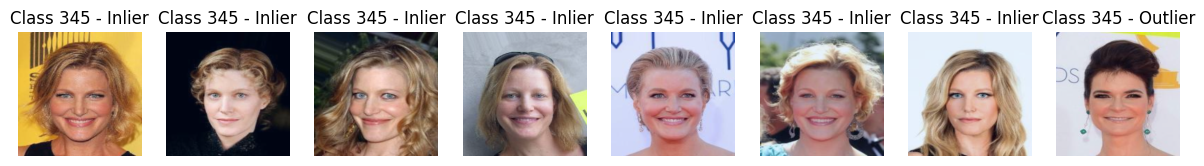

In [88]:
show_class_images(train_dataset_with_embeddings, global_indices, outliers_global, selected_classes)

Вуаля! По итогу, можно использовать эмбеддинги и аутлаеры для нахождения выбросов и фиксить неточность разметки

## 5. "What’s the Best Face Detector? Comparing Dlib, OpenCV DNN, Yunet, Pytorch-MTCNN, and RetinaFace"

https://medium.com/pythons-gurus/what-is-the-best-face-detector-ab650d8c1225

### 1. Тема статьи
Статья посвящена выбору лучшей модели для детекции лиц - первому шаге в пайплане распознавания лиц. Автор проводит тесты нескольких популярных моделей и предоставляет информацию о том, какие из них наиболее эффективны в реальных условиях, пытается найти компромисс между точностью и скоростью.


### 2. Данные
Автор проводит тесты на своих данных - небольшая выборка из 1024 кадров из сериалов, что позволяет объективно оценить производительность моделей. Хоть выборка и показалась мне небольшой, но она разнообразна (с частично закрытыми лицами, разными углами, etc) и приближенна к данным в продуктовых задачах.


### 3. CPU модели
- **YuNet**: разработана с упором на производительность, и её размер модели значительно меньше, чем у более крупных моделей. Например, YuNet имеет всего 75 856 параметров, в то время как RetinaFace имеет 27 293 600 параметров, что позволяет YuNet работать на устройствах с ограниченными вычислительными ресурсами. Быстро работает в режиме реального времени, показывает неплохую accuracy, особенно на крупных лицах.

https://colab.research.google.com/drive/1_uOdesvdnDLG8fZAMJKqbTNrlbxgdUD0

### 4. GPU модели
- **Dlib**: это реализация на C++ с Python-обёрткой, которая сохраняет баланс между точностью, производительностью и удобством. Но между точностью и производительностью Dlib существует сильный компромисс в зависимости от параметра апсемплинга. Чем больше апсемплинг, тем точнее модель, но это увеличивает нагрузку на GPU. Точность Dlib оказалась не такой высокой, как ожидал автор, учитывая скорость, но была хороша в минимизации ложных положительных.
- **OpenCV DNN**: Самый быстрый на GPU. Также автор отметил, что модель сложно имплементируется и указал свою статью в помощь https://medium.com/@amosstaileyyoung/build-opencv-with-dnn-and-cuda-for-gpu-accelerated-face-detection-27a3cdc7e9ce
- **MTCNN**: Медленный и не оправдывает себя по сравнению с другими моделями, хотя и показывает чуть большую точность, чем OpenCV
- **RetinaFace**: показала себя самой точной моделью среди открытых решений для детекции лиц.
Хорошо справляется с нахождением лиц в сложных ситуациях, таких как частичные отражения или лица на картинках в кадре.
Она достаточно быстра, сопоставимо с MTCNN, номедленнее, чем YuNet.

Приведу сравнительную таблицу характеристик, чего мне не хватило в статье

| Model            | Overall Accuracy | Top 1 Accuracy | Average Duration by Frame (2160p) | CPU/GPU |
|------------------|------------------|-----------------|----------------------------------|---------|
| YuNet            | 74.9             | 89.8            | 0.15                             | CPU     |
| Dlib (No Upsampling) | 64.9         | 87.3            | 0.31                             | GPU     |
| Dlib (Upsampling=1) | 73.0           | 89.3            | 1.20                             | GPU     |
| OpenCV DNN       | 50.6             | 77.0            | 0.12                             | GPU     |
| Pytorch MTCNN    | 62.6             | 80.3            | 0.29                             | GPU     |
| RetinaFace       | 89.0             | 97.3            | 0.25                             | GPU     |



### 5. Выводы и их соответствие представленным данным
Автор приводит полезный вывод, что выбор модели зависит от того, что важнее для конкретной задачи — скорость или точность. Например, для определённых приложений (например, работы в реальном времени на слабых устройствах) YuNet может быть идеальным решением, в то время как для высокоточных задач распознавания лиц на больших и частично скрытых изображениях стоит выбрать RetinaFace.


